### We can construct a mosaic of nearby tiles using this method: https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/discussion/36738

# Import Necessary Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Input, Dense, Activation, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential, Model
import math
from PIL import Image

# Defining Constants

In [4]:
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 64
MODEL_BATCH_SIZE = 32
KERNEL_SIZE = 3
IMG_DIMS = 256
EPOCHS = 10
DATA_PATH = 'data/train-jpg/'
THRESHOLD = 0.5

# Preprocess data
---

### Obtain Labels

In [5]:
train_data = pd.read_csv('data/train_v2.csv')

curr_count = 0
unique_labels = {}
multihot = {}
for line in train_data['tags'].values:
    for label in line.split():
        if label not in unique_labels:
            unique_labels[label] = curr_count
            curr_count += 1

mapping = {}

n_labels = len(unique_labels)

for k, v in unique_labels.items():
    mapping[k] = np.zeros(n_labels, dtype=np.float16)
    mapping[k][v] = 1.0
    mapping[k] = tf.constant(mapping[k])


label2name = {v: k for k, v in unique_labels.items()}

print(label2name)

{0: 'haze', 1: 'primary', 2: 'agriculture', 3: 'clear', 4: 'water', 5: 'habitation', 6: 'road', 7: 'cultivation', 8: 'slash_burn', 9: 'cloudy', 10: 'partly_cloudy', 11: 'conventional_mine', 12: 'bare_ground', 13: 'artisinal_mine', 14: 'blooming', 15: 'selective_logging', 16: 'blow_down'}


### View Head of dataset

In [6]:
train_data.head(n = 11)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


### Auxiliary Function for multi-hotting

In [7]:
def multihot(label_tensor):
    label_string = label_tensor.decode("utf-8")
    label = tf.zeros([n_labels], dtype=tf.float16)
    tokens = label_string.split(' ')

    for k in range(len(tokens)):
        label += mapping[tokens[k]]

    return label

### Auxiliary function for converting tensor filename to image

In [8]:
def readImage(filename_tensor, resize = [IMG_DIMS, IMG_DIMS]):
    full_path = DATA_PATH + filename_tensor.decode("utf-8") + '.jpg'

    img = Image.open(full_path).convert("RGB")
    img = np.asarray(img) / 255
    img = tf.convert_to_tensor(img)
    img = tf.image.resize(img, resize)

    return img

### Function to grab the label from the filename

In [9]:
def symbolicRealMapping(filename_tensor, label_tensor):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """

    img = tf.numpy_function(readImage, [filename_tensor], tf.float32)
    label_multihot = tf.numpy_function(multihot, [label_tensor], tf.float16)

    # # print(f"{img = }")

    return img, label_multihot

### Create the spanning dataset

In [10]:
# first pass, construct a list of image strips

file_paths = train_data['image_name'].values
labels_strings = train_data['tags'].values
spanning_dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels_strings))
spanning_dataset = spanning_dataset.map(symbolicRealMapping)
spanning_dataset = spanning_dataset.prefetch(tf.data.AUTOTUNE)
dataset_length = len(spanning_dataset)
print(f"{dataset_length}")

40479


### Split into a test and train set, batch each

In [11]:
train_length = math.floor(0.8 * dataset_length)
train_ds, val_ds = spanning_dataset.take(train_length).batch(TRAIN_BATCH_SIZE), spanning_dataset.skip(train_length).batch(TEST_BATCH_SIZE)

### Display a target image

In [12]:
def show_image(idx, X, y):
    img = tf.cast(X[idx] * 255, tf.uint8)
    # print(f"{img = }")
    indices = tf.where(y[idx] == 1).numpy()
    label_arr = []
    for index in indices:
        label_arr.append(label2name[index[0]])
    label = ' '.join(label_arr)
    plt.imshow(img)
    plt.title(label)
    plt.show()

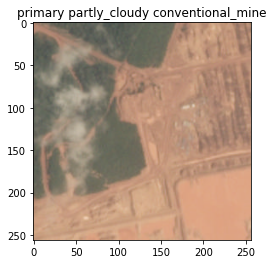

In [13]:
batch = None

for e in train_ds:
    batch = e
    break

show_image(24, batch[0], batch[1])

# Prepare the model
---

### Define evaluation function

In [14]:
def macro_f1(y, y_hat):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, THRESHOLD), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

### Model Architecture

In [15]:
ds_model = Sequential()

ds_model.add(Conv2D(filters = 28,
    kernel_size = (KERNEL_SIZE, KERNEL_SIZE),
    input_shape = (IMG_DIMS, IMG_DIMS, 3),
    activation='relu',
    padding = 'Same'))
ds_model.add(MaxPooling2D(pool_size = (2, 2)))

ds_model.add(Conv2D(filters = 28,
    kernel_size = (KERNEL_SIZE, KERNEL_SIZE),
    activation='relu'))
ds_model.add(MaxPooling2D(pool_size = (2, 2)))

ds_model.add(Conv2D(filters = 28,
    kernel_size = (KERNEL_SIZE, KERNEL_SIZE),
    activation='relu'))
ds_model.add(MaxPooling2D(pool_size = (2, 2)))

ds_model.add(Flatten())

ds_model.add(Dense(200, activation = 'relu'))
ds_model.add(Dropout(0.2))

ds_model.add(Dense(100, activation = 'relu'))
ds_model.add(Dropout(0.1))

ds_model.add(Dense(n_labels, activation = 'sigmoid'))

### Compile the model

In [16]:
opt = K.optimizers.Adam(learning_rate=0.01)

ds_model.compile(optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=macro_f1)

# Train model
---

In [17]:
ds_history = ds_model.fit(train_ds,
    epochs = EPOCHS,
    batch_size = MODEL_BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1)

Epoch 1/10
1012/1012 [==============================] - 894s 882ms/step - loss: 0.2219 - macro_f1: 0.1809 - val_loss: 0.1896 - val_macro_f1: 0.2317
Epoch 2/10
1012/1012 [==============================] - 255s 253ms/step - loss: 0.1876 - macro_f1: 0.2404 - val_loss: 0.1697 - val_macro_f1: 0.2801
Epoch 3/10
1012/1012 [==============================] - 254s 251ms/step - loss: 0.1733 - macro_f1: 0.2697 - val_loss: 0.1654 - val_macro_f1: 0.3031
Epoch 4/10
1012/1012 [==============================] - 253s 250ms/step - loss: 0.1638 - macro_f1: 0.2906 - val_loss: 0.1511 - val_macro_f1: 0.3295
Epoch 5/10
1012/1012 [==============================] - 255s 252ms/step - loss: 0.1552 - macro_f1: 0.3106 - val_loss: 0.1503 - val_macro_f1: 0.3342
Epoch 6/10
1012/1012 [==============================] - 256s 253ms/step - loss: 0.1481 - macro_f1: 0.3249 - val_loss: 0.1491 - val_macro_f1: 0.3507
Epoch 7/10
1012/1012 [==============================] - 255s 252ms/step - loss: 0.1429 - macro_f1: 0.3367 - val_

# View results
---

### Store the history in a dataframe

In [25]:
history_df = pd.DataFrame(ds_history.history)
history_df

,loss,macro_f1,val_loss,val_macro_f1
0,0.221860,0.180921,0.189618,0.231732
1,0.187614,0.240436,0.169681,0.280053
2,0.173281,0.269671,0.165397,0.303144
3,0.163828,0.290649,0.151137,0.329494
4,0.155187,0.310577,0.150251,0.334217
5,0.148113,0.324882,0.149050,0.350686
6,0.142854,0.336741,0.147946,0.357314
7,0.135858,0.355354,0.147928,0.360452
8,0.129867,0.368309,0.154816,0.354595
9,0.122695,0.385044,0.174155,0.350634


### Plotting the loss

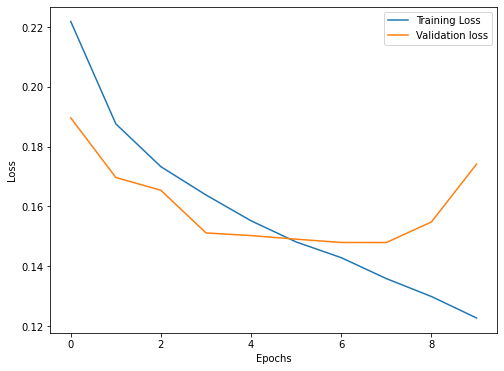

In [26]:
plt.figure(figsize=(8,6))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
history_df['loss'].plot(label='Training Loss')
history_df['val_loss'].plot(label='Validation loss')
plt.legend(loc='upper right')

### Grabbing the first batch

In [20]:
batch0 = None
for batch in train_ds:
    batch0 = batch
    break

# NOTE: Batch1 is a TUPLE, not a tensor.
# It's comprised of two separate tensors, where the first
# element is the set of feature tensors of dimension 64x256x256x3
# because each batch is comprised of 64 elements, each being
# 256x256x3 images.
# The second element in the tuple is the tensor of multihot encodings

print(f"{batch0 = }")

batch0 = (<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[0.38039216, 0.4392157 , 0.4117647 ],
         [0.36862746, 0.4392157 , 0.4       ],
         [0.36862746, 0.4392157 , 0.39607844],
         ...,
         [0.38039216, 0.4392157 , 0.40392157],
         [0.38039216, 0.43529412, 0.40392157],
         [0.37254903, 0.42745098, 0.40392157]],

        [[0.36862746, 0.42745098, 0.4       ],
         [0.36078432, 0.42745098, 0.39215687],
         [0.36078432, 0.43137255, 0.39215687],
         ...,
         [0.37254903, 0.43137255, 0.4       ],
         [0.37254903, 0.42745098, 0.40392157],
         [0.36862746, 0.42352942, 0.40392157]],

        [[0.3529412 , 0.41568628, 0.39215687],
         [0.34901962, 0.41568628, 0.3882353 ],
         [0.3529412 , 0.42352942, 0.3882353 ],
         ...,
         [0.3647059 , 0.41960785, 0.39607844],
         [0.36078432, 0.41960785, 0.4       ],
         [0.35686275, 0.41960785, 0.4       ]],

        ...,

        [[0.3647059 , 0

### Auxiliary function to convert from labels to names

In [50]:
def reverseHot(label_numpy):
    label = []
    for i in label_numpy:
        label.append(label2name[i])
    return ' '.join(label)

prediction = 'primary clear'


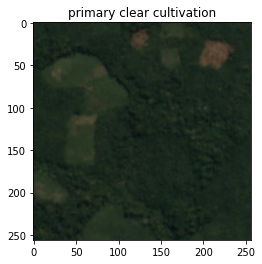

In [83]:
image_idx = 31
y_hat_probs = ds_model.predict(batch0[0])
prediction_hot = (y_hat_probs[image_idx] > THRESHOLD).nonzero()[0]
prediction = reverseHot(prediction_hot)
print(f'{prediction = }')
show_image(image_idx, batch0[0], batch0[1])